In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'/Users/ryan/github/prosodic')
from llmdh import *
import prosodic

In [2]:
df=SonnetLLM.gather()
# df

In [15]:
def get_foot_type_results(txt):
    txt=txt.strip()
    if txt.startswith('** Sonnet **\n'):
        txt=txt[txt.index('\n')+1:]
    
    with logmap(announce=False) as lm:
        try:
            with lm.verbosity(0):
                poem=prosodic.Text(txt)
                parses = [
                    l.best_parse 
                    for l in poem.lines 
                    if len(l.best_parse.slots)>=4
                ]
                
            if not parses:
                lm.error(f'no parses for {txt}')
                return {}
            
            perc1=np.mean([
                int(parse.slots[3].meter_val=='s') 
                for parse in parses
            ])
            perc2=np.mean([
                int(pos.meter_str=='ww')
                for parse in parses
                for pos in parse.positions
            ])
            if np.isnan(perc1) or np.isnan(perc2):
                lm.error(f'nan in {perc1}, {perc2} for {txt}')
                return {}
            return {
                'meter_perc_lines_fourthpos_s':perc1,
                'meter_mpos_ww':perc2,
                'num_lines_incl':len(parses),
            }
        except Exception as e:
            lm.error(e)
            return {}
        


In [16]:


from tqdm import tqdm
tqdm.pandas()

@classmethod
@cache
def gather_parse_shakespeare(self,force=False):
    path=os.path.join(PATH_DATA,'gather_parse_shakespeare.json')
    if not force and os.path.exists(path):
        return pd.read_json(path)
    
    with logmap('gathering and parsing shakespeare') as lm:
        odf=pd.DataFrame(
            {
                'sonnet_num':stanza.num,
                'sonnet_fline':stanza.lines[0].txt,
                **get_foot_type_results(stanza.txt)
            }
            for stanza in lm.iter_progress(
                prosodic.Text(
                    fn=os.path.join(PATH_DATA,'shakespeare-sonnets.txt')
                ).stanzas
            )
        )
        odf.to_json(path, orient='records')
        return odf

SonnetLLM.gather_parse_shakespeare = gather_parse_shakespeare

In [17]:
SonnetLLM.gather_parse_shakespeare()

,sonnet_num,sonnet_fline,meter_perc_lines_fourthpos_s,meter_mpos_ww
0,1,"FROM fairest creatures we desire increase,",0.928571,0.014388
1,2,"When forty winters shall beseige thy brow,",1.000000,0.007246
2,3,"Look in thy glass, and tell the face thou viewest",1.000000,0.014085
3,4,"Unthrifty loveliness, why dost thou spend",0.785714,0.053030
4,5,"Those hours, that with gentle work did frame",0.857143,0.044776
...,...,...,...,...
149,150,"O, from what power hast thou this powerful might",0.928571,0.036765
150,151,Love is too young to know what conscience is;,0.928571,0.029197
151,152,"In loving thee thou know'st I am forsworn,",1.000000,0.013889
152,153,"Cupid laid by his brand, and fell asleep:",0.928571,0.014388


In [22]:

@classmethod
@cache
def gather_parse(self, lim=None):
    with logmap('gathering and parsing') as lm:
        
        # shak
        dfshak = self.gather_parse_shakespeare().iloc[:lim]
        if lim is None: lim = len(dfshak)

        df=self.gather().sample(frac=1)
        o=[]
        for i,row in lm(df.iterrows(),desc='parsing llm results',total=len(df)):
            if lim and len(o)>=lim: break
            odx=get_foot_type_results(row.result)
            if odx: o.append((i,odx))
        results_df=pd.DataFrame([x[1] for x in o],index=[x[0] for x in o])
        odf1=df.join(results_df)
            
        return pd.concat([
            dfshak.assign(author='Shakespeare',model='Shakespeare',num_lines_incl=14),
            odf1.assign(author='LLM'),
        ])



SonnetLLM.gather_parse = gather_parse

In [26]:
df = SonnetLLM.gather_parse()

⎾ gathering and parsing @ 2024-03-16 05:28:46,412
￨ parsing llm results:   2%|▏         | 154/7027 [04:36<3:25:22,  1.79s/it]


In [27]:
df

,sonnet_num,sonnet_fline,meter_perc_lines_fourthpos_s,meter_mpos_ww,author,num_lines_incl,model,system_prompt,example_prompts,user_prompt,input_data,response,result,is_valid
0,1.0,"FROM fairest creatures we desire increase,",0.928571,0.014388,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,"When forty winters shall beseige thy brow,",1.000000,0.007246,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,"Look in thy glass, and tell the face thou viewest",1.000000,0.014085,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,"Unthrifty loveliness, why dost thou spend",0.785714,0.053030,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,"Those hours, that with gentle work did frame",0.857143,0.044776,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,NaN,NaN,NaN,NaN,LLM,NaN,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a summer's day, so fair...","**Sonnet**\n\nMy love, a summer's day, so fair...",True
2251,NaN,NaN,NaN,NaN,LLM,NaN,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a rose, with petals sof...","**Sonnet**\n\nMy love, a rose, with petals sof...",True
5079,NaN,NaN,NaN,NaN,LLM,NaN,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a summer's day, so fair...","**Sonnet**\n\nMy love, a summer's day, so fair...",True
2078,NaN,NaN,NaN,NaN,LLM,NaN,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a rose, with petals sof...","**Sonnet**\n\nMy love, a rose, with petals sof...",True


In [28]:
df[['meter_perc_lines_fourthpos_s','meter_mpos_ww','num_lines_incl','author']].dropna()

,meter_perc_lines_fourthpos_s,meter_mpos_ww,num_lines_incl,author
0,0.928571,0.014388,14.0,Shakespeare
1,1.000000,0.007246,14.0,Shakespeare
2,1.000000,0.014085,14.0,Shakespeare
3,0.785714,0.053030,14.0,Shakespeare
4,0.857143,0.044776,14.0,Shakespeare
...,...,...,...,...
5738,1.000000,0.000000,14.0,LLM
834,1.000000,0.000000,14.0,LLM
6526,1.000000,0.000000,14.0,LLM
2838,1.000000,0.000000,14.0,LLM


In [31]:
import plotnine as p9
x='meter_mpos_ww'
y='meter_perc_lines_fourthpos_s'
figdf = pd.concat(
    gdf.assign(group_count=len(gdf)) 
    for g,gdf in df.groupby([x,y])
)
figdf

,sonnet_num,sonnet_fline,meter_perc_lines_fourthpos_s,meter_mpos_ww,author,num_lines_incl,model,system_prompt,example_prompts,user_prompt,input_data,response,result,is_valid,group_count
105,106.0,When in the chronicle of wasted time,0.857143,0.000000,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2209,NaN,NaN,0.928571,0.000000,LLM,14.0,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a summer's day, so brig...","**Sonnet**\n\nMy love, a summer's day, so brig...",True,1
27,28.0,"How can I then return in happy plight,",1.000000,0.000000,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61
101,102.0,"My love is strengthen'd, though more weak in s...",1.000000,0.000000,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61
6922,NaN,NaN,1.000000,0.000000,LLM,14.0,gemini-pro,Please generate a text according to the formal...,[],"Write 1 Shakespearean sonnet, imitating exactl...",{},"**Sonnet**\n\nMy love, a summer's day, so fair...","**Sonnet**\n\nMy love, a summer's day, so fair...",True,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,8.0,"Music to hear, why hear'st thou music sadly?",0.857143,0.081481,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
141,142.0,"Love is my sin and thy dear virtue hate,",0.785714,0.083333,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
134,135.0,"Whoever hath her wish, thou hast thy 'Will,'",0.642857,0.085938,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
35,36.0,"Let me confess that we two must be twain,",0.785714,0.093750,Shakespeare,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


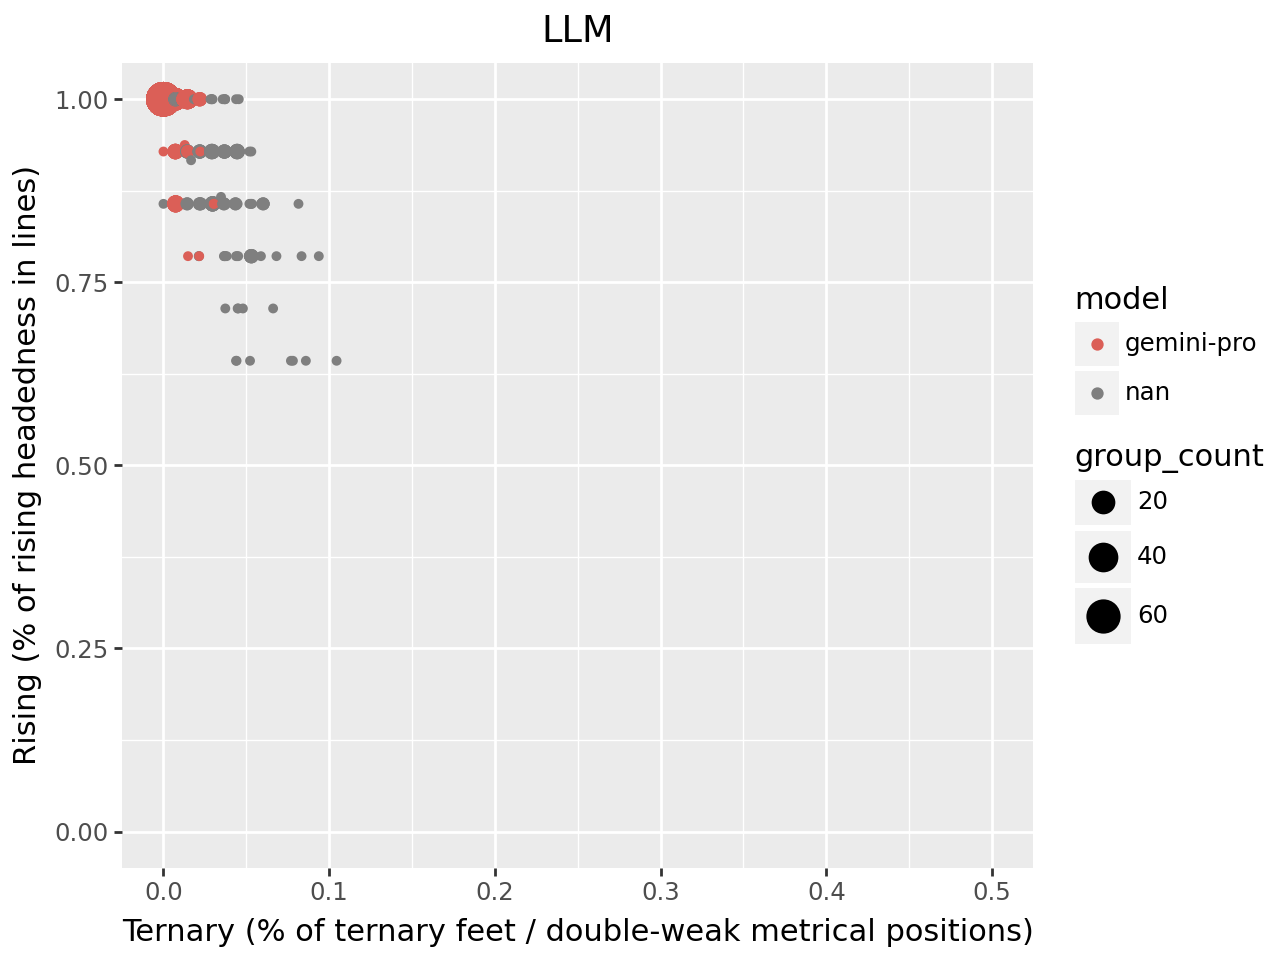

In [37]:
fig = p9.ggplot(figdf, p9.aes(x='meter_mpos_ww', y='meter_perc_lines_fourthpos_s', color='model', size='group_count'))
fig+= p9.geom_point()
fig+= p9.scale_y_continuous(limits=(0,1))
fig+= p9.scale_x_continuous(limits=(0,.5))
fig+= p9.labs(
    x='Ternary (% of ternary feet / double-weak metrical positions)',
    y='Rising (% of rising headedness in lines)',
    title='LLM'
)
fig